In [18]:
# Schritt 1: Laden der notwendigen Bibliotheken
import pandas as pd

# Schritt 2: Einlesen des Datensatzes mit Semikolon als Trennzeichen
# Da der Datensatz mit Semikolon (;) getrennt ist, geben wir das explizit über das Argument 'sep' an.
df = pd.read_csv('to_predict.csv', sep=';', decimal=',')

# Wir lassen uns die ersten fünf Zeilen anzeigen, um einen ersten Eindruck vom Aufbau zu bekommen.
df.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
0,0.277235,-0.025677,-0.118431,-0.996390,-0.952688,-0.965410,-0.996680,-0.947807,-0.964858,-0.938698,...,-0.502178,-0.764893,0.021715,0.092319,0.284888,-0.627470,-0.815897,0.166483,-0.094444,2
1,0.298220,-0.022571,-0.138333,-0.196046,0.006589,-0.383593,-0.279066,-0.051674,-0.373783,0.248414,...,-0.211873,-0.578501,-0.234068,0.731836,-0.919809,0.781004,-0.755885,0.259203,-0.033670,4
2,0.277211,-0.015174,-0.112219,-0.997011,-0.975575,-0.989928,-0.997572,-0.973843,-0.990112,-0.942149,...,-0.159021,-0.541282,0.031435,-0.325374,-0.558906,0.318582,-0.936694,0.057989,-0.008128,13
3,0.308660,-0.007576,-0.080628,-0.444185,-0.179110,-0.240722,-0.470408,-0.261380,-0.267160,-0.348934,...,0.148057,-0.118939,-0.236939,-0.260576,-0.256543,-0.837161,-0.828188,0.161358,0.123115,24
4,0.289617,-0.010774,-0.133259,-0.993367,-0.995373,-0.935635,-0.993694,-0.995246,-0.925559,-0.935766,...,-0.268589,-0.594786,-0.225719,0.298398,0.502886,-0.451063,-0.838166,0.158459,0.116581,13


In [19]:
# Schritt 3: Wir schauen ob es Spalten gibt die nicht den Datentyp 'float64' entsprechen.

non_float_columns = df.select_dtypes(exclude=['float64']).columns
print(non_float_columns)

Index(['subject'], dtype='object')


In [20]:
# Schritt 4: Überprüfung auf fehlende Werte im Datensatz

# Wir zählen alle NaN-Werte pro Spalte.
# Fehlende Werte können auf Probleme bei der Messung, Speicherung oder Verarbeitung hinweisen
# und sollten vor dem Training eines Modells behandelt werden.
missing_values = df.isnull().sum()

# Wir filtern auf Spalten, die tatsächlich fehlende Werte enthalten
missing_values = missing_values[missing_values > 0]

# Ausgabe der betroffenen Spalten (falls vorhanden)
print("Spalten mit fehlenden Werten:")
print(missing_values if not missing_values.empty else "Keine fehlenden Werte gefunden.")

Spalten mit fehlenden Werten:
Keine fehlenden Werte gefunden.


In [21]:
# Schritt 5: Überprüfung auf Ausreißer außerhalb des normierten Bereichs [-1, 1]

# Zuerst filtern wir nur die numerischen Spalten heraus (ohne z. B. 'subject' oder 'activity')
numerical_df = df.iloc[:, :-2]

# Prüfen, ob irgendwo Werte < -1 vorkommen
under_min = (numerical_df < -1).sum()
under_min = under_min[under_min > 0]

# Prüfen, ob irgendwo Werte > 1 vorkommen
over_max = (numerical_df > 1).sum()
over_max = over_max[over_max > 0]

# Ausgabe der Ergebnisse
print("Spalten mit Werten < -1:")
print(under_min if not under_min.empty else "Keine Werte kleiner -1 gefunden.")

print("\nSpalten mit Werten > 1:")
print(over_max if not over_max.empty else "Keine Werte größer 1 gefunden.")


Spalten mit Werten < -1:
Keine Werte kleiner -1 gefunden.

Spalten mit Werten > 1:
Keine Werte größer 1 gefunden.


In [22]:
# Schritt 6: Überprüfung auf doppelte Datensätze

# Wir suchen nach vollständig identischen Zeilen im gesamten DataFrame – 
# also Duplikate über alle Spalten hinweg (inkl. subject und activity).
# Das ist wichtig, weil Duplikate das Modell verzerren können,
# z. B. durch zu hohe Gewichtung bestimmter Muster.
duplicate_rows = df[df.duplicated()]

# Ausgabe der Anzahl und optional auch eine Vorschau der Duplikate
print(f"Anzahl vollständig doppelter Zeilen im Datensatz: {duplicate_rows.shape[0]}")

# Optional: erste doppelte Zeilen anzeigen
if not duplicate_rows.empty:
    display(duplicate_rows.head())
else:
    print("Keine doppelten Zeilen gefunden.")

# Schritt 6.1: Doppelte Zeilen ohne Rücksicht auf 'subject' und 'activity'
# Wir ignorieren dazu die letzten beiden Spalten (subject, activity).
feature_columns = df.columns[:-2]
duplicate_features_only = df[df.duplicated(subset=feature_columns)]

print(f"\nAnzahl doppelter Zeilen bezogen nur auf die Messwerte (ohne subject und activity): {duplicate_features_only.shape[0]}")

if not duplicate_features_only.empty:
    display(duplicate_features_only.head())
else:
    print("Keine doppelten Messzeilen gefunden (unabhängig von subject und activity).")


Anzahl vollständig doppelter Zeilen im Datensatz: 0
Keine doppelten Zeilen gefunden.

Anzahl doppelter Zeilen bezogen nur auf die Messwerte (ohne subject und activity): 0
Keine doppelten Messzeilen gefunden (unabhängig von subject und activity).


In [23]:
# Schritt 7: Suche und Entfernung doppelter Feature-Spalten (identische Inhalte),
# inkl. Übersichtstabelle zur manuellen Prüfung

print(f"Anzahl Spalten vor Entfernen der Duplikate: {df.shape[1]}")

# Initialisieren
duplicate_feature_columns = set()
duplicate_pairs = []
columns = df.columns

# Vergleich jeder Spalte mit jeder anderen
for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        
        if df[col1].equals(df[col2]):
            duplicate_feature_columns.add(col2)  # col2 wird als Duplikat markiert
            duplicate_pairs.append((col1, col2))  # Speichern für Übersichtstabelle

# Übersicht über identische Spaltenpaare
duplicates_df = pd.DataFrame(duplicate_pairs, columns=['Spalte_1', 'Spalte_2'])

print(f"Anzahl identischer Spaltenpaare: {len(duplicates_df)}")
if not duplicates_df.empty:
    display(duplicates_df)
else:
    print("Keine identischen Spalten gefunden.")

# Entfernen der Duplikate aus dem DataFrame
df_cleaned = df.drop(columns=duplicate_feature_columns)

print(f"Neue Anzahl Spalten nach Entfernen der Duplikate: {df_cleaned.shape[1]}")

# Schritt 7.1: Anzeige der entfernten Spaltennamen
removed_columns = sorted(list(duplicate_feature_columns))
print(f"\nListe der entfernten Spalten ({len(removed_columns)}):")
for col in removed_columns:
    print(f"- {col}")

Anzahl Spalten vor Entfernen der Duplikate: 562
Anzahl identischer Spaltenpaare: 24


,Spalte_1,Spalte_2
0,tBodyAccMag-mean(),tBodyAccMag-sma()
1,tBodyAccMag-mean(),tGravityAccMag-mean()
2,tBodyAccMag-mean(),tGravityAccMag-sma()
3,tBodyAccMag-std(),tGravityAccMag-std()
4,tBodyAccMag-mad(),tGravityAccMag-mad()
5,tBodyAccMag-max(),tGravityAccMag-max()
6,tBodyAccMag-min(),tGravityAccMag-min()
7,tBodyAccMag-sma(),tGravityAccMag-mean()
8,tBodyAccMag-sma(),tGravityAccMag-sma()
9,tBodyAccMag-energy(),tGravityAccMag-energy()


Neue Anzahl Spalten nach Entfernen der Duplikate: 541

Liste der entfernten Spalten (21):
- fBodyAccMag-sma()
- fBodyBodyAccJerkMag-sma()
- fBodyBodyGyroJerkMag-sma()
- fBodyBodyGyroMag-sma()
- tBodyAccJerkMag-sma()
- tBodyAccMag-sma()
- tBodyGyroJerkMag-sma()
- tBodyGyroMag-sma()
- tGravityAccMag-arCoeff()1
- tGravityAccMag-arCoeff()2
- tGravityAccMag-arCoeff()3
- tGravityAccMag-arCoeff()4
- tGravityAccMag-energy()
- tGravityAccMag-entropy()
- tGravityAccMag-iqr()
- tGravityAccMag-mad()
- tGravityAccMag-max()
- tGravityAccMag-mean()
- tGravityAccMag-min()
- tGravityAccMag-sma()
- tGravityAccMag-std()


In [24]:
# Schritt 8: Erkennen und Entfernen von konstanten oder nahezu konstanten Merkmalen

from sklearn.feature_selection import VarianceThreshold

# Achtung: Wir analysieren nur die numerischen Messwerte – z. B. ohne 'subject' und 'activity'
feature_data = df_cleaned.iloc[:, :-2]

# Schritt 8.1: Berechnung der Varianz jeder Spalte
# VarianceThreshold entfernt standardmäßig alle Features mit Varianz = 0 (konstant)
selector = VarianceThreshold(threshold=0.0)
selector.fit(feature_data)

# Finden der konstanten Spalten
constant_columns = feature_data.columns[~selector.get_support()]

print(f"Anzahl konstanter Merkmale (Varianz = 0): {len(constant_columns)}")
if len(constant_columns) > 0:
    print("Konstante Merkmale:")
    print(list(constant_columns))

# Schritt 8.2: Finden von Merkmalen mit sehr geringer Varianz (z. B. < 0.001)
# Hinweis: Da alle Features auf [-1, 1] normiert sind, gilt 0.001 als konservative Schwelle für "nahezu konstante" Merkmale.
low_variance_threshold = 0.001
low_var_selector = VarianceThreshold(threshold=low_variance_threshold)
low_var_selector.fit(feature_data)

# Finden der Merkmale mit Varianz unterhalb der Schwelle
low_variance_columns = feature_data.columns[~low_var_selector.get_support()]

print(f"\nAnzahl Merkmale mit Varianz < {low_variance_threshold}: {len(low_variance_columns)}")
if len(low_variance_columns) > 0:
    print("Niedrig-Varianz-Merkmale:")
    print(list(low_variance_columns))

# Schritt 8.3: Entfernen der konstanten und niedrig-varianten Merkmale aus dem DataFrame
columns_to_remove = set(constant_columns).union(set(low_variance_columns))
df_cleaned2 = df_cleaned.drop(columns=columns_to_remove)

print(f"\nNeue Anzahl Merkmale nach Entfernung: {df_cleaned2.shape[1]}")

Anzahl konstanter Merkmale (Varianz = 0): 0

Anzahl Merkmale mit Varianz < 0.001: 1
Niedrig-Varianz-Merkmale:
['tBodyAcc-mean()-Y']

Neue Anzahl Merkmale nach Entfernung: 540


Anzahl Messungen pro Subjekt:
subject
2     302
4     317
9     288
10    294
12    320
13    327
18    364
20    354
24    381
Name: count, dtype: int64


<Axes: title={'center': 'Messverteilung pro Subjekt'}, xlabel='subject'>

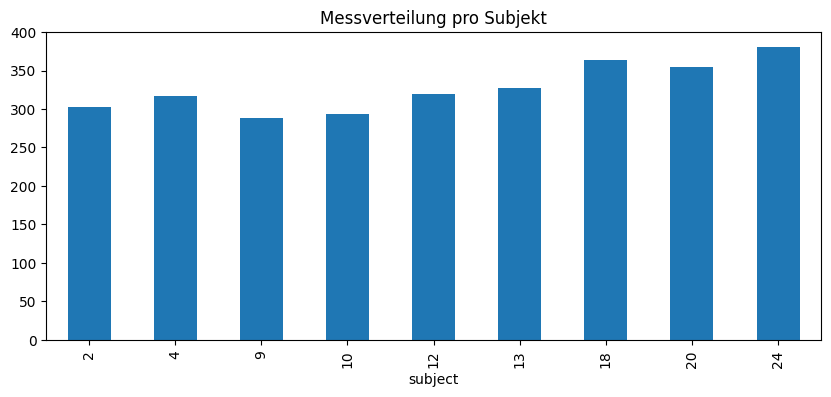

In [25]:
# Schritt 11: Analyse der Subjektverteilung

# Wir prüfen, wie viele Messungen es pro Person gibt
# Falls einige Subjekte sehr wenige oder extrem viele Werte haben,
# kann das Modell personenspezifisch verzerrt werden

subject_counts = df_cleaned2['subject'].value_counts().sort_index()
print("Anzahl Messungen pro Subjekt:")
print(subject_counts)

# Optional: Visualisierung
subject_counts.plot(kind='bar', title='Messverteilung pro Subjekt', figsize=(10, 4))

In [26]:
# Schritt 13: Finden von Features mit nur wenigen unterschiedlichen Werten

# Wir zählen die Anzahl eindeutiger Werte pro Feature.
# Merkmale mit z. B. nur 1–2 Werten sind oft wenig informativ (wie binär, konstant)
# und können entfernt oder speziell behandelt werden.

unique_value_counts = df_cleaned2.iloc[:, :-2].nunique()  # exclude subject + activity
low_info_features = unique_value_counts[unique_value_counts <= 2]

print(f"Anzahl Features mit ≤ 2 eindeutigen Werten: {len(low_info_features)}")
if not low_info_features.empty:
    print("Betroffene Spalten:")
    print(low_info_features)


Anzahl Features mit ≤ 2 eindeutigen Werten: 0
